# Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras import layers

In [ ]:
from tabulate import tabulate

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Functions

In [ ]:
# Source: https://scipython.com/blog/the-lorenz-attractor/

def generate_points(IC, r, s=10, b=8/3):
  # Lorenz paramters and initial conditions.
  rho, sigma, beta = r, s, b
  u0, v0, w0 = IC

  # Maximum time point and total number of time points.
  tmax, n = 100, 10000

  def lorenz(dt, X, r, s, b):
    x, y, z = X
    x_dot = s*(y - x)
    y_dot = x*(r - z) - y
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

  # Integrate the Lorenz equations.
  soln = solve_ivp(lorenz, (0, tmax), (u0, v0, w0), args=(rho ,sigma , beta),
                  dense_output=True)
  # Interpolate solution onto the time grid, t.
  t = np.linspace(0, tmax, n)
  x, y, z = soln.sol(t)

  return np.array([x,y,z,np.repeat(r,n)])

In [ ]:
def split_data(data, ratio):
  n_train = int(data.shape[1]*ratio)  # number of samples in training data

  train_data, test_data = data[:,:n_train], data[:,n_train:]

  x_train, y_train = train_data[:,:-1], train_data[:,1:]
  x_test, y_test = test_data[:,:-1], test_data[:,1:]

  return x_train, y_train, x_test, y_test

In [ ]:
def init_model(input_dim, d=2):

  '''
  d : number of hidden layers
  '''

  model = tf.keras.models.Sequential()
  model.add(tf.keras.Input(shape=(input_dim,)))

  for _ in range(d):
    model.add(layers.Dense(32, activation='relu'))

  model.add(layers.Dense(3))

  return model

In [ ]:
def accuracy_per_epoch(x1, y1, E, losses, depth=2):

  for loss in losses:

    L = []

    for ep in E:

      '''
      model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(x1.shape[0],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3)
      ])
      '''
      model = init_model(x1.shape[0], d=depth)

      # Compiling the model
      model.compile(optimizer='adam', loss=loss)

      # Training the model
      fit = model.fit(x1.T, y1[:3,:].T, epochs=ep, batch_size=32)  # remove rho from the output training data to have the same dims for MSE

      L.append(fit.history['loss'][-1])

      del model

    plt.plot(E, L, label=loss)

  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('loss value')
  plt.yscale('log')
  plt.title('Accuracy by number of epochs')
  plt.show()


In [ ]:
def accuracy_per_depth(x1, y1, D, losses):

  for loss in losses:

    L = []

    for depth in D:

      model = init_model(x1.shape[0], d=depth)

      # Compiling the model
      model.compile(optimizer='adam', loss=loss)

      # Training the model
      fit = model.fit(x1.T, y1[:3,:].T, epochs=50, batch_size=32)  # remove rho from the output training data to have the same dims for MSE

      L.append(fit.history['loss'][-1])

      del model

    plt.plot(D, L, label=loss)

  plt.legend()
  plt.xlabel('number of hidden layers')
  plt.ylabel('loss value')
  plt.yscale('log')
  plt.title('Accuracy by depth of neural network')
  plt.show()

In [ ]:
def compare_loss_functions(x1, y1, losses, epochs=50, depth=2):

  perf = {}

  for loss in losses:
    model = init_model(x1.shape[0], d=depth)

    # Compiling the model
    model.compile(optimizer='adam', loss=loss)

    # Training the model
    fit = model.fit(x1.T, y1[:3,:].T, epochs=epochs, batch_size=32, validation_split=0.2, verbose=0)

    mse = fit.history['val_loss'][-1]
    perf[loss] = mse

    plt.plot([i+1 for i in range(epochs)], fit.history['loss'], label=loss)
    del model

  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('loss value')
  plt.yscale('log')
  plt.title('Loss value per epoch')
  plt.show()

  # Print the performance table
  table = []
  for loss, mse in perf.items():
    table.append([loss, mse])

  headers = ["Loss function", "MSE"]
  print(tabulate(table, headers=headers))

In [ ]:
def plot_3d(points):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(points[0], points[1], points[2], c='r', marker='o', s=0.6)
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')
  plt.show()

In [ ]:
def plot_3d_subplots(arrays, titles):
  fig = plt.figure(figsize=(15, 5))
  for i, array in enumerate(arrays):
    ax = fig.add_subplot(1, len(arrays), i+1, projection='3d')
    ax.scatter(*array, s=2)
    ax.set_title(titles[i])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
  plt.show()

In [ ]:
def compare_predictions_plot(model, data, rho, rounds=1500):

  pred = model.predict(data[:,:32].T, verbose=0)
  predicted_array = pred[0,:]

  for i in range(1,rounds):
    pred = model.predict(np.vstack((pred.T, np.repeat(rho,32))).T, verbose=0)
    predicted_array = np.vstack((predicted_array, pred[0,:]))

  plot_3d_subplots([data[:3,:], predicted_array.T], [r'Actual $\rho$={}'.format(rho), r'Predicted $\rho$={}'.format(rho)])

In [ ]:
def countdown_transition(A):
  n_cols = A.shape[1]
  for i in range(n_cols):
    current_sign = np.sign(A[0, i])
    for j in range(i+1, n_cols):
      if np.sign(A[0, j]) != current_sign:
        A[3, i] = j - i
        break
    else:
      return A[:, :i]
  return A

In [ ]:
def split_data_2(data, ratio):
  n_train = int(data.shape[1]*ratio)  # number of samples in training data

  train_data, test_data = data[:,:n_train], data[:,n_train:]

  x_train, y_train = train_data[:3,:], train_data[-1,:]
  x_test, y_test = test_data[:3,:], test_data[-1,:]

  return x_train, y_train, x_test, y_test

# Data generation

Generating data for $\rho=10$, $\rho=28$ and $\rho=40$.

In [ ]:
data_10 = generate_points([0,1,1.05], 10)
data_28 = generate_points([0,1,1.05], 28)
data_40 = generate_points([0,1,1.05], 40)

In [ ]:
data_28[:3,:].shape

(3, 10000)

In [ ]:
# x-label training set, y-label training set, x-label testing set, y-label testing set
x1_10, y1_10, x2_10, y2_10 = split_data(data_10, 0.7)
x1_28, y1_28, x2_28, y2_28 = split_data(data_28, 0.7)
x1_40, y1_40, x2_40, y2_40 = split_data(data_40, 0.7)

In [ ]:
x2_10.shape

(4, 2999)

In [ ]:
np.concatenate((x1_10, x1_28, x1_40), axis=1).shape

(4, 20997)

In [ ]:
x1 = np.concatenate((x1_10, x1_28, x1_40), axis=1)
y1 = np.concatenate((y1_10, y1_28, y1_40), axis=1)
x2 = np.concatenate((x2_10, x2_28, x2_40), axis=1)
y2 = np.concatenate((y2_10, y2_28, y2_40), axis=1)

In [ ]:
y1[:3,:].shape

(3, 20997)

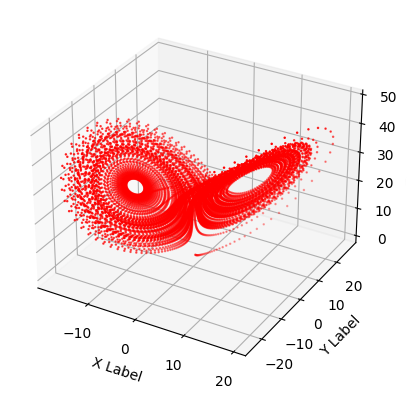

In [ ]:
plot_3d(data_28[:3,:])

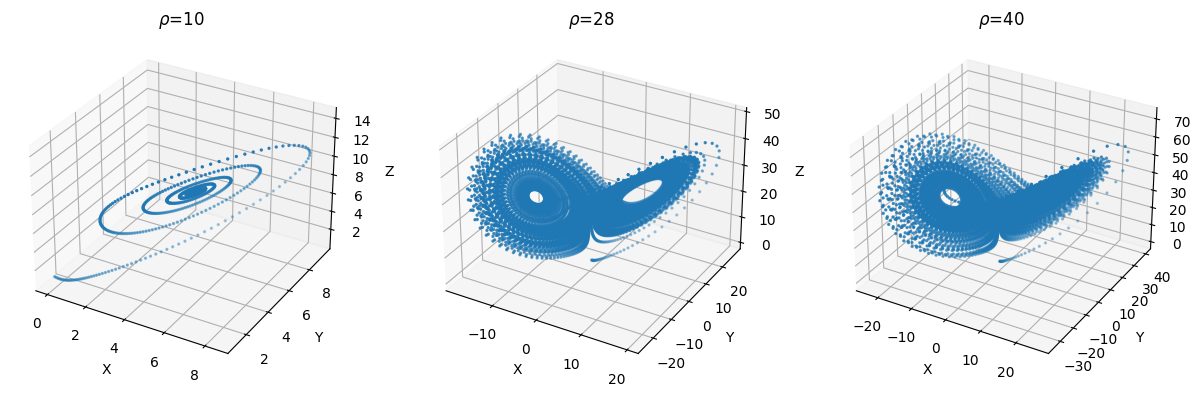

In [ ]:
plot_3d_subplots([data_10[:3,:], data_28[:3,:], data_40[:3,:]], [r'$\rho$=10', r'$\rho$=28', r'$\rho$=40'])

# Neural Networks - Loss functions

Choosing which loss function would give better accuracy.

In [ ]:
# Tuto: https://www.tensorflow.org/tutorials/quickstart/beginner?hl=en

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, activation='relu', input_shape=(x1.shape[0],)),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(3)
])

In [ ]:
# Compiling the model

model.compile(optimizer='adam', loss='mae')

# Training the model

model.fit(x1.T, y1[:3,:].T, epochs=20, batch_size=32)  # remove rho from the output training data to have the same dims for MSE

Epoch 1/20
219/219 [==============================] - 1s 1ms/step - loss: 2.0158
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0745
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0670
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0596
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0543
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0535
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0504
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0394
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0403
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0302
Epoch 11/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0319
Epoch 12/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0262
Epoch 13/20
219/219 [====

In [ ]:
accuracy_per_epoch(x1, y1, [10*i for i in range(1,10)])   # Don't run this, function is modified

In [ ]:
epochs = [10*i for i in range(1,6)]
losses = ['mse', 'mae', 'huber', 'logcosh']

In [ ]:
accuracy_per_epoch(x1, y1, epochs, losses)

In [ ]:
epochs = [100, 200, 300]
losses = ['mse', 'mae', 'huber', 'logcosh']

In [ ]:
accuracy_per_depth(x1, y1, [2, 4, 8, 16], losses)

In [ ]:
compare_loss_functions(x1, y1, losses)

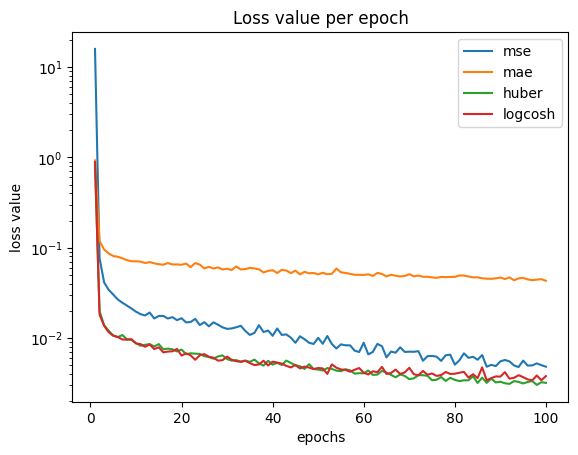

Loss function           MSE
---------------  ----------
mse              0.00688562
mae              0.109246
huber            0.00555586
logcosh          0.00751468


In [ ]:
compare_loss_functions(x1, y1, losses, epochs=100)

# Neural Networks - Predictions

Training the model to predict the next states of the Lorenz system.

In [ ]:
# Create, compile and train the model

model = init_model(4, d=3)
model.compile(optimizer='adam', loss='huber')
model.fit(x1.T, y1[:3,:].T, epochs=100, batch_size=32, verbose=0)

In [ ]:
tf.keras.backend.eval(model.optimizer.lr)

0.001

In [ ]:
x2[:,:32].shape

(4, 32)

In [ ]:
y_pred = model.predict(x2[:,:32].T)

1/1 [==============================] - 0s 98ms/step


In [ ]:
y_pred.T.shape

(3, 32)

In [ ]:
new_y_pred = model.predict(np.vstack((y_pred.T, np.repeat(10,32))).T)

1/1 [==============================] - 0s 173ms/step


In [ ]:
y_pred.shape

(32, 3)

In [ ]:
np.vstack((y_pred.T, np.repeat(10,32))).shape

(4, 32)

In [ ]:
errors = []

pred = model.predict(x2_10[:,:32].T)
errors.append(np.linalg.norm(pred.T[:,0] - y2_10[:3,0])/np.linalg.norm(y2_10[:3,0]))

for i in range(1,2999):
  pred = model.predict(np.vstack((pred.T, np.repeat(10,32))).T, verbose=0)
  error = np.linalg.norm(pred.T[:,0] - y2_10[:3,i])/np.linalg.norm(y2_10[:3,i])
  errors.append(error)

#plt.plot([i for i in range(1000)], errors)

1/1 [==============================] - 0s 39ms/step


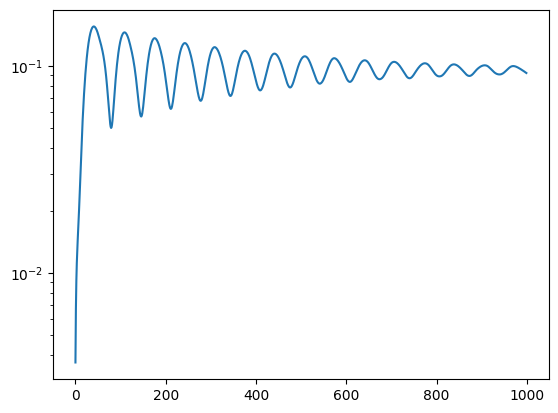

In [ ]:
plt.plot([i for i in range(1000)], errors)
plt.yscale('log')
plt.show()

In [ ]:
errors_28 = []

pred = model.predict(x2_28[:,:32].T)
errors_28.append(np.linalg.norm(pred.T[:,0] - y2_28[:3,0])/np.linalg.norm(y2_28[:3,0]))

for i in range(1,2999):
  pred = model.predict(np.vstack((pred.T, np.repeat(28,32))).T, verbose=0)
  error = np.linalg.norm(pred.T[:,0] - y2_28[:3,i])/np.linalg.norm(y2_28[:3,i])
  errors_28.append(error)

#plt.plot([i for i in range(300)], errors_28)

1/1 [==============================] - 0s 35ms/step


In [ ]:
errors_40 = []

pred = model.predict(x2_40[:,:32].T)
errors_40.append(np.linalg.norm(pred.T[:,0] - y2_40[:3,0])/np.linalg.norm(y2_40[:3,0]))

for i in range(1,2999):
  pred = model.predict(np.vstack((pred.T, np.repeat(40,32))).T, verbose=0)
  error = np.linalg.norm(pred.T[:,0] - y2_40[:3,i])/np.linalg.norm(y2_40[:3,i])
  errors_40.append(error)

#plt.plot([i for i in range(500)], errors_40)

In [ ]:
len(errors_40)

2999

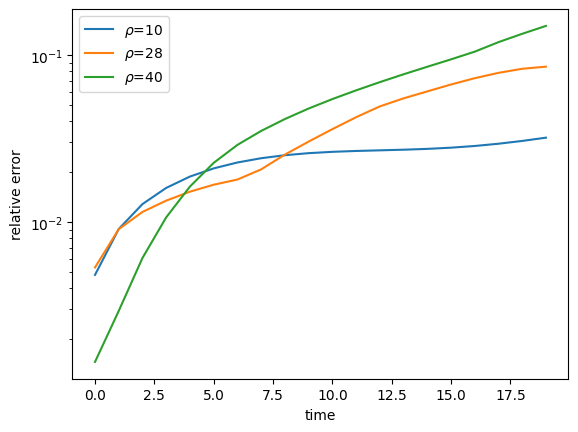

In [ ]:
plt.plot([i for i in range(20)], errors[:20], label=r'$\rho$=10')
plt.plot([i for i in range(20)], errors_28[:20], label=r'$\rho$=28')
plt.plot([i for i in range(20)], errors_40[:20], label=r'$\rho$=40')
plt.legend()
plt.xlabel('time')
plt.ylabel('relative error')
plt.yscale('log')
plt.show()

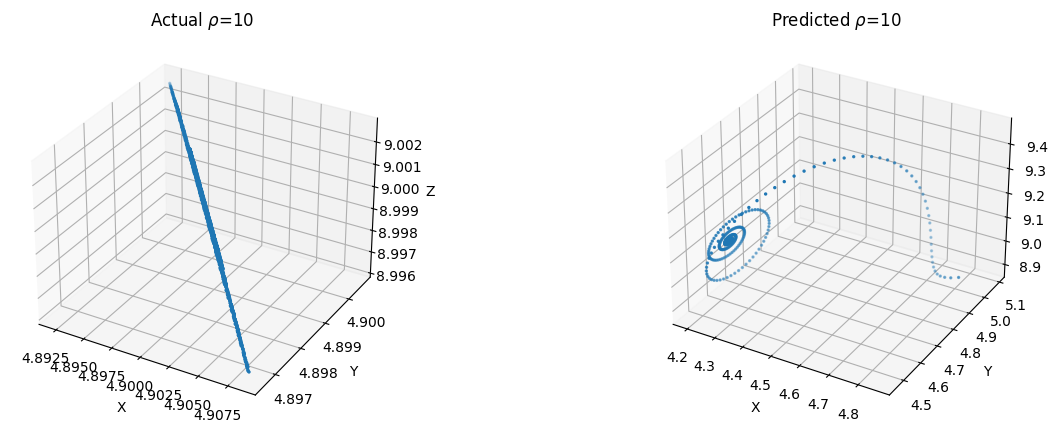

In [ ]:
compare_predictions_plot(model, x2_10, 10, rounds=x2_10.shape[1])

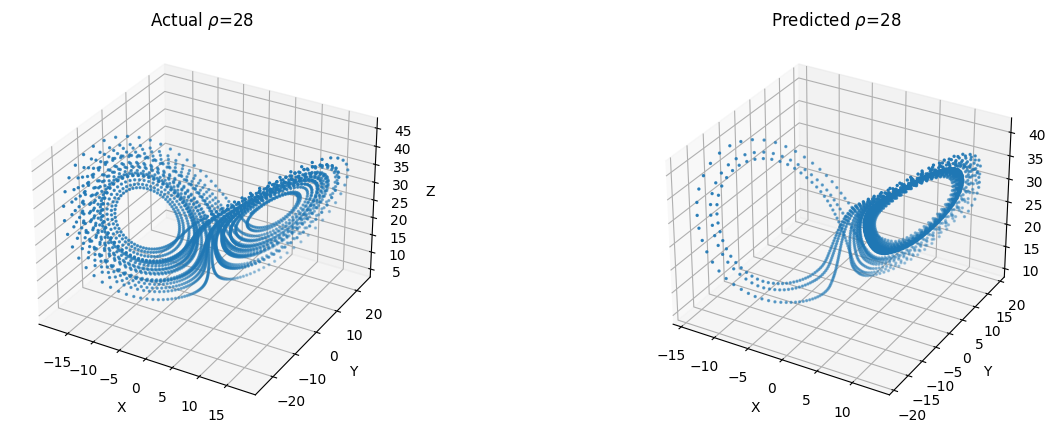

In [ ]:
compare_predictions_plot(model, x2_28, 28, rounds=x2_28.shape[1])

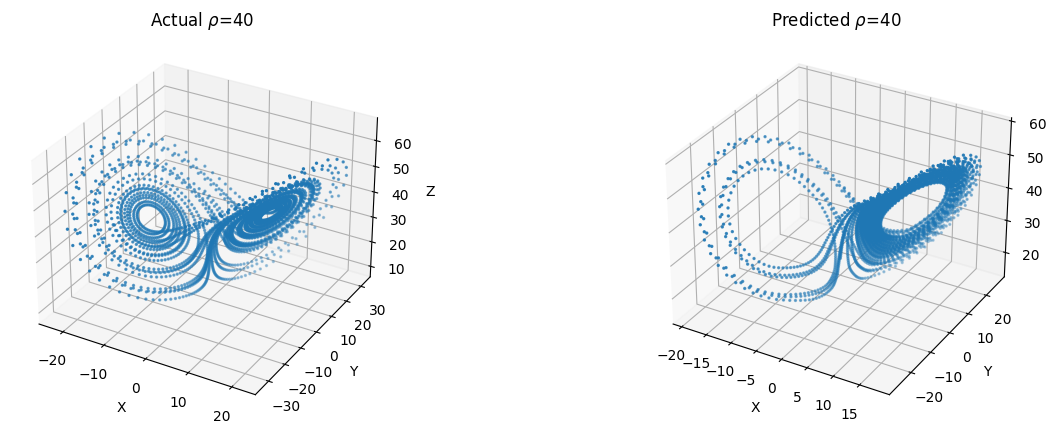

In [ ]:
compare_predictions_plot(model, x2_40, 40, rounds=x2_40.shape[1])

In [ ]:
data_17 = generate_points([0,1,1.05], 17)
# predicted_17 = np.array([])

pred = model.predict(data_17[:,:32].T)
predicted_17 = pred[0,:]

for i in range(1,1500):
  pred = model.predict(np.vstack((pred.T, np.repeat(17,32))).T, verbose=0)
  predicted_17 = np.vstack((predicted_17, pred[0,:]))

1/1 [==============================] - 0s 34ms/step


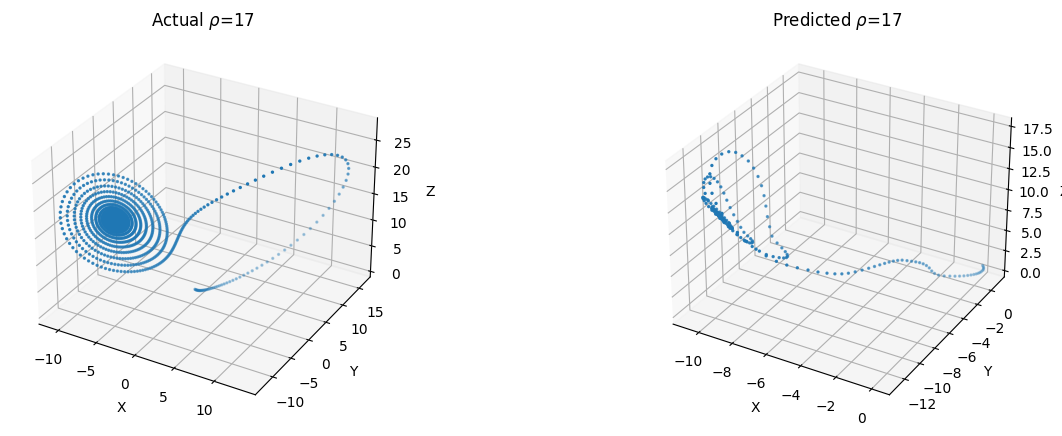

In [ ]:
plot_3d_subplots([data_17[:3,:], predicted_17.T], [r'Actual $\rho$=17', r'Predicted $\rho$=17'])

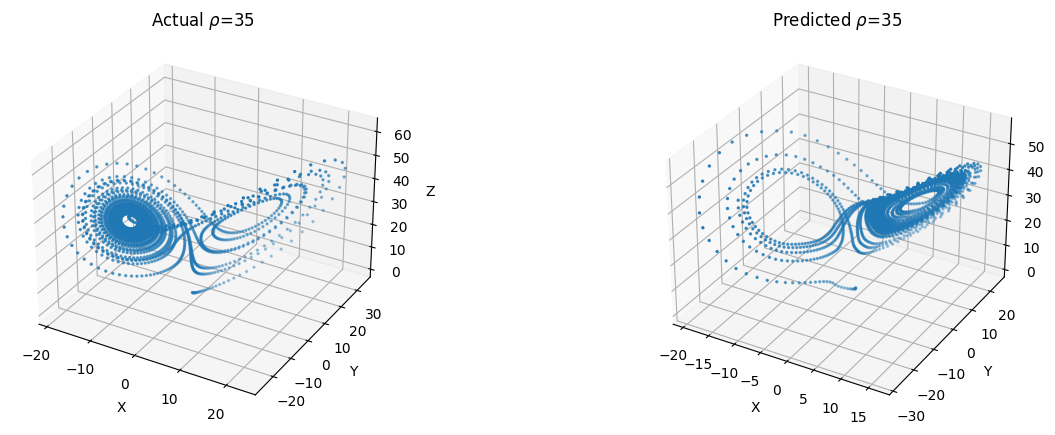

In [ ]:
data_35 = generate_points([0,1,1.05], 35)
compare_predictions_plot(model, data_35[:,:2000], 35, rounds=2000)

# Neural Networks - Transition prediction

For $\rho=28$, we have two distinct "wings" (see plots in previous sections). Can we train a neural network to predict when we transition from one "wing" to another?

In [ ]:
D_28 = countdown_transition(data_28)

In [ ]:
D_28.shape

(4, 9872)

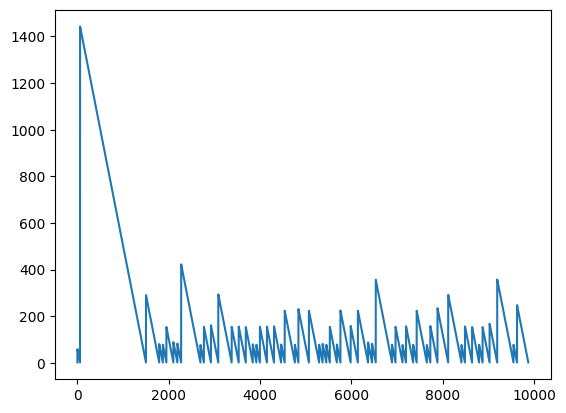

In [ ]:
plt.plot(D_28[3,:])

In [ ]:
x1, y1, x2, y2 = split_data_2(D_28, 0.7)

In [ ]:
x1.shape

(3, 6910)

In [ ]:
model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, activation='relu', input_shape=(x1.shape[0],)),
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(5, activation='relu'),
  tf.keras.layers.Dense(1)
])

In [ ]:
# Compiling the model

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([100,300],[1e-2,1e-3,1e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)
model_2.compile(optimizer=optim, loss='huber')

# Training the model

history = model_2.fit(x1.T, y1.T, epochs=500, batch_size=32, verbose=0)

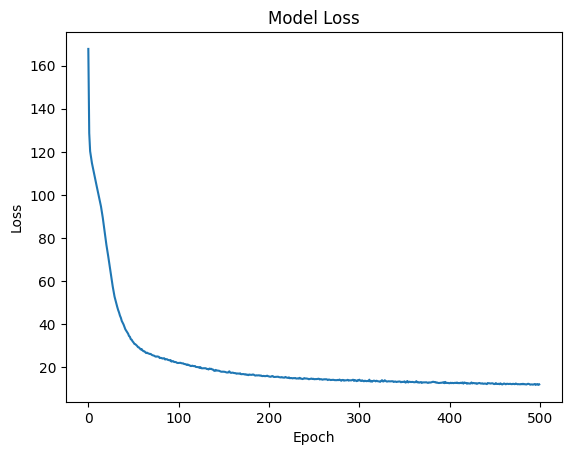

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()